In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 1. Load Data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [5]:
tr_df = train_df('DataMRI/Training')

In [6]:
tr_df

,Class Path,Class
0,DataMRI/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,DataMRI/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,DataMRI/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,DataMRI/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,DataMRI/Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,DataMRI/Training/meningioma/Tr-me_1053.jpg,meningioma
5708,DataMRI/Training/meningioma/Tr-me_0403.jpg,meningioma
5709,DataMRI/Training/meningioma/Tr-me_0365.jpg,meningioma
5710,DataMRI/Training/meningioma/Tr-me_0371.jpg,meningioma


In [7]:
ts_df = test_df('DataMRI/Testing')

In [8]:
ts_df

,Class Path,Class
0,DataMRI/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,DataMRI/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,DataMRI/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,DataMRI/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,DataMRI/Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,DataMRI/Testing/meningioma/Te-me_0080.jpg,meningioma
1307,DataMRI/Testing/meningioma/Te-me_0094.jpg,meningioma
1308,DataMRI/Testing/meningioma/Te-me_0137.jpg,meningioma
1309,DataMRI/Testing/meningioma/Te-me_0123.jpg,meningioma


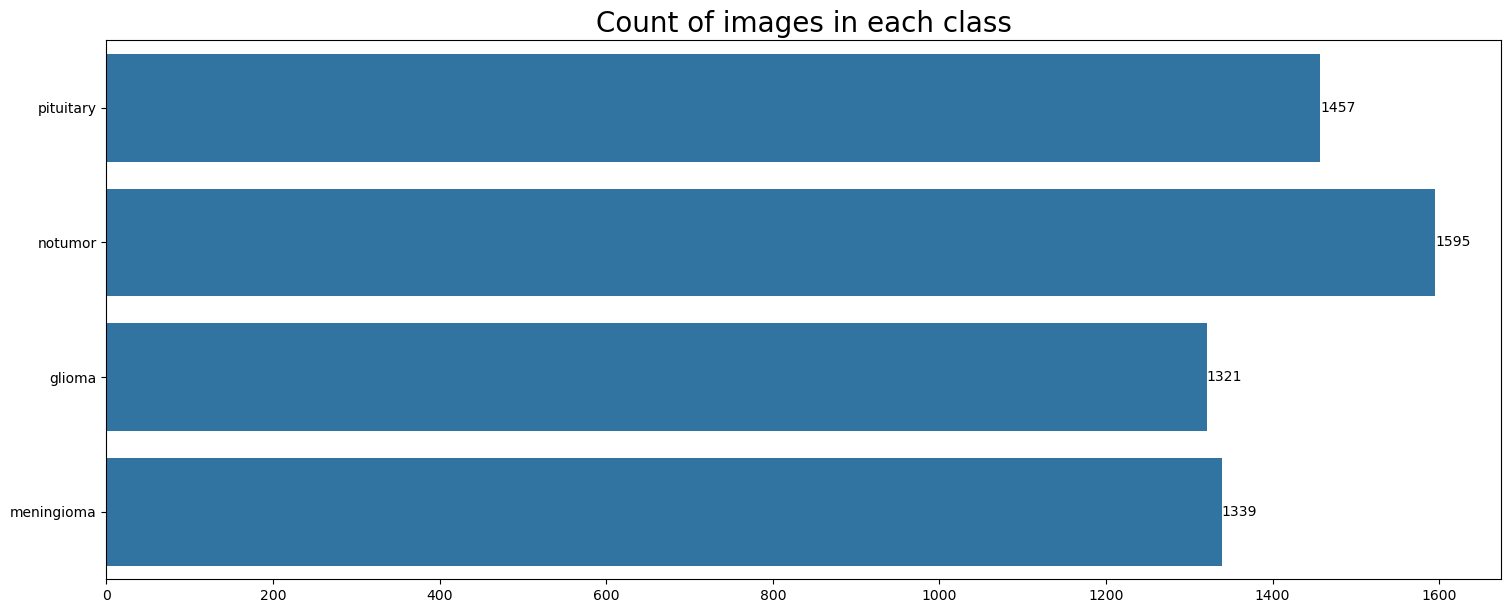

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(18,7))
ax = sns.countplot(data=tr_df , y='Class')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()




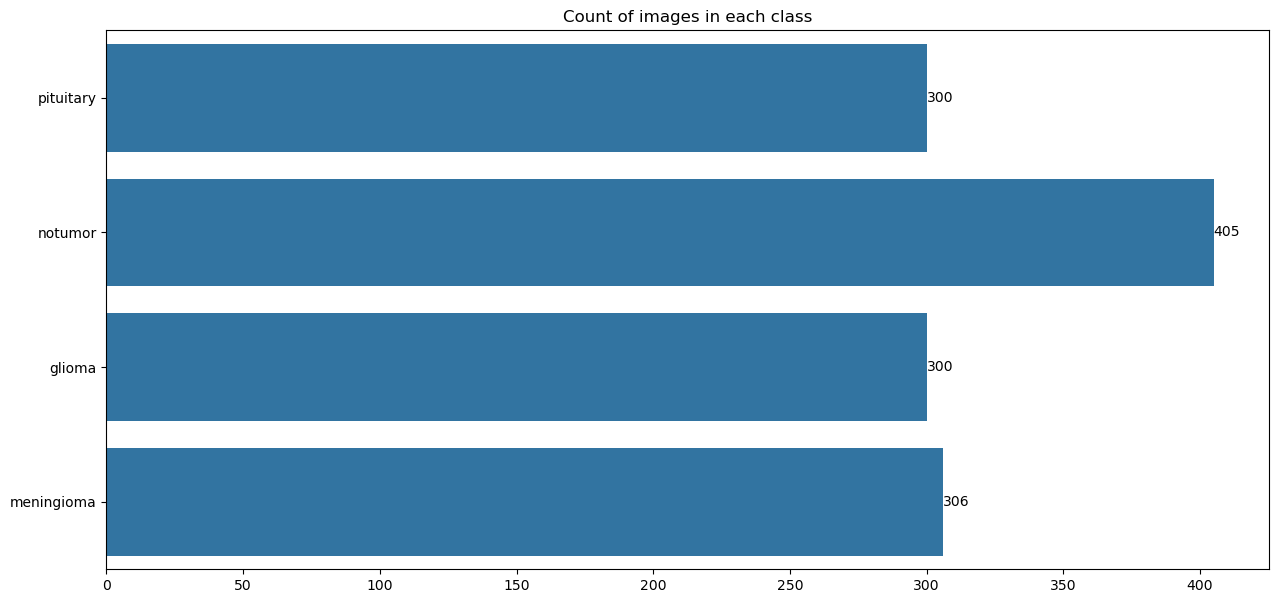

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'])

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

# 2. Split Data

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
991,DataMRI/Testing/glioma/Te-gl_0129.jpg,glioma
1023,DataMRI/Testing/meningioma/Te-me_0107.jpg,meningioma
61,DataMRI/Testing/pituitary/Te-pi_0197.jpg,pituitary
1078,DataMRI/Testing/meningioma/Te-me_0274.jpg,meningioma
814,DataMRI/Testing/glioma/Te-gl_0219.jpg,glioma
...,...,...
764,DataMRI/Testing/glioma/Te-gl_0136.jpg,glioma
554,DataMRI/Testing/notumor/Te-no_0206.jpg,notumor
978,DataMRI/Testing/glioma/Te-glTr_0004.jpg,glioma
1199,DataMRI/Testing/meningioma/Te-me_0182.jpg,meningioma


In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


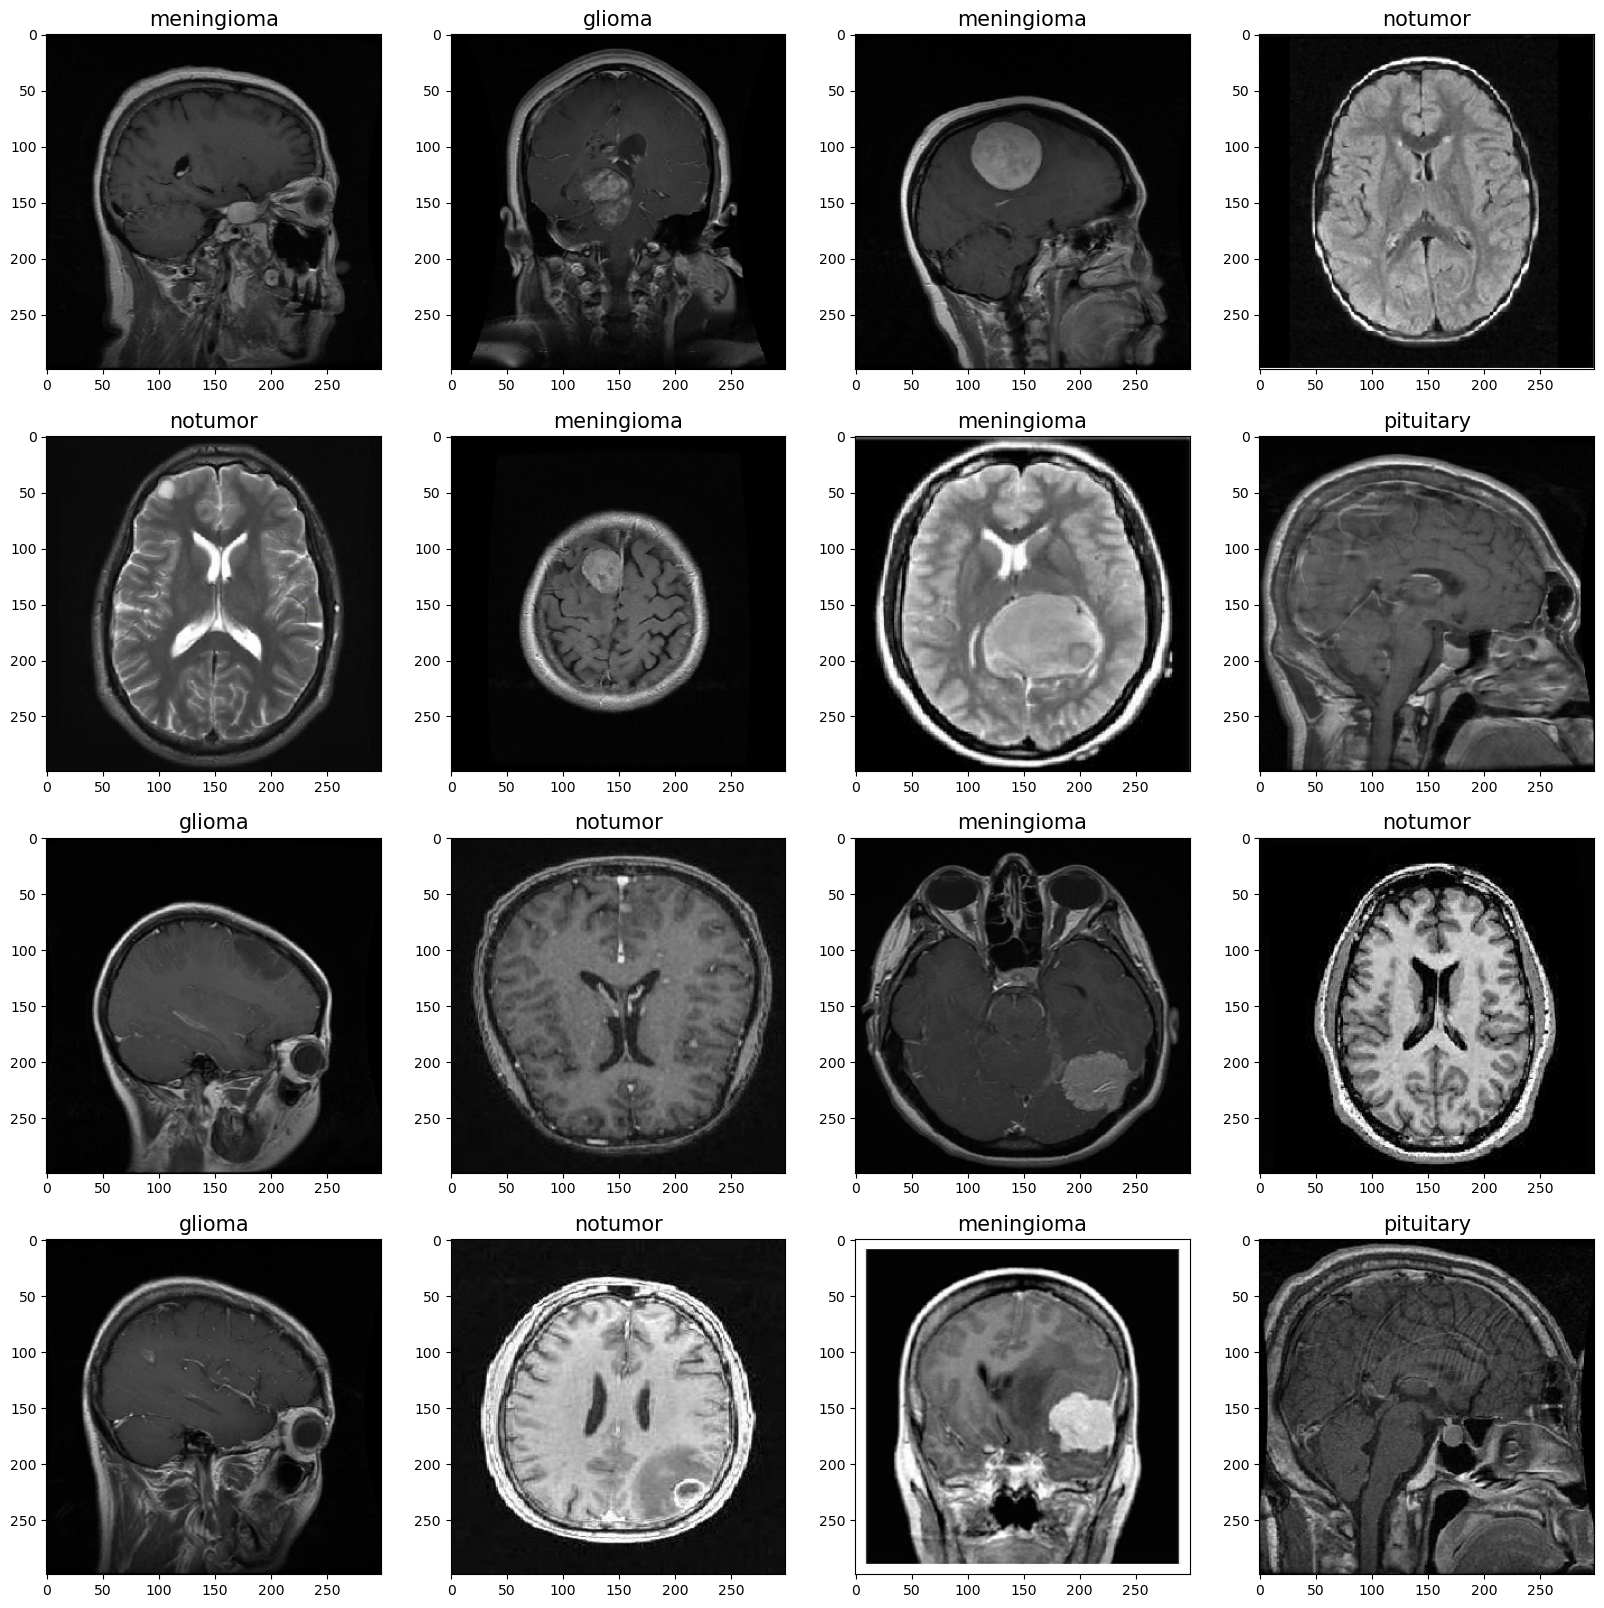

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning

In [15]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

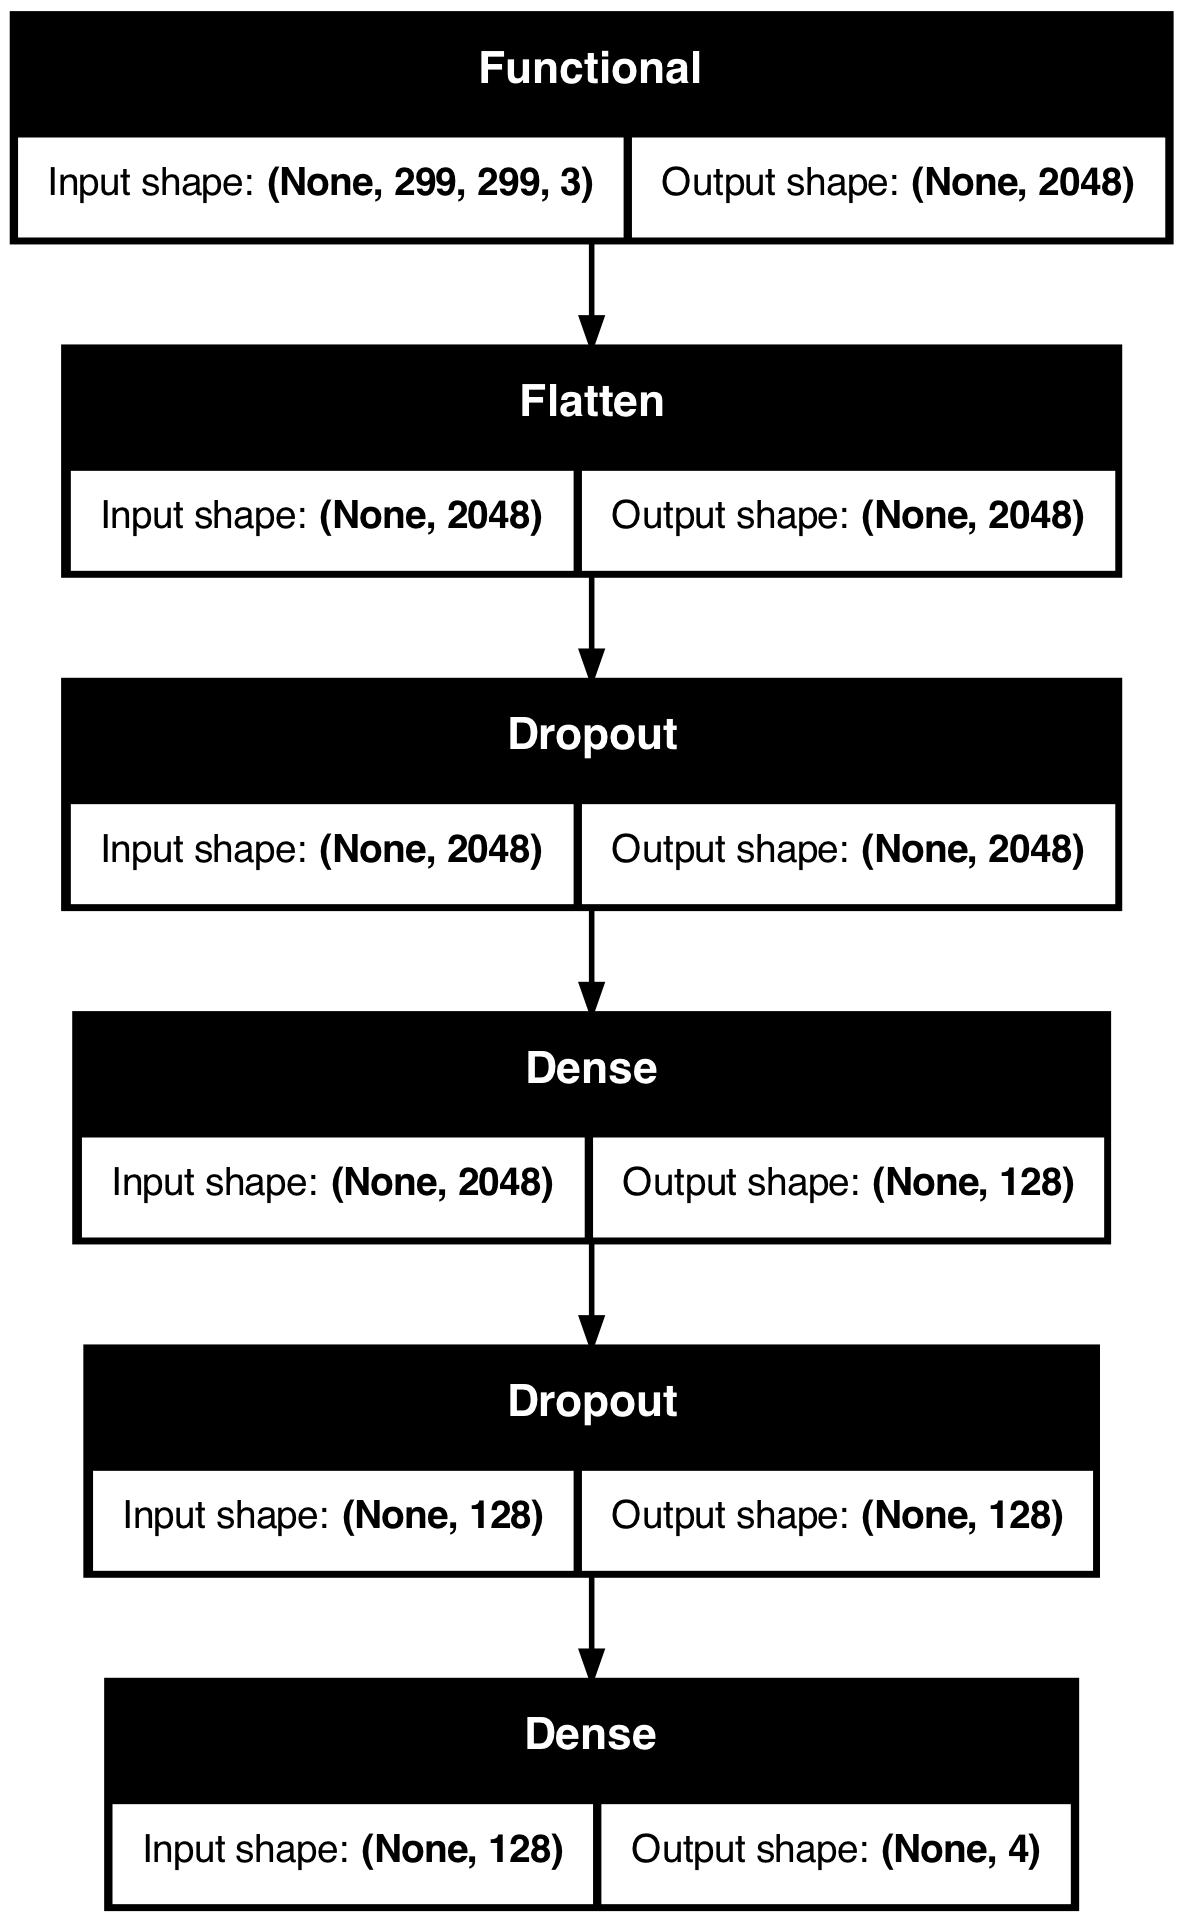

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
 70/179 ━━━━━━━━━━━━━━━━━━━━ 1:06:15 36s/step - accuracy: 0.5318 - loss: 1.4149 - precision: 0.5777 - recall: 0.2235

KeyboardInterrupt: 